<a href="https://colab.research.google.com/github/shenzhun/machine-learning-prep/blob/master/tensorflow/day14_feature_column.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import datetime
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers,models


# Printing log
def printlog(info):
    nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print("\n"+"=========="*8 + "%s"%nowtime)
    print(info+'...\n\n')

In [16]:
printlog("step1: prepare dataset...")

dftrain_raw = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/titanic/train.csv")
dftest_raw = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/titanic/test.csv")

dfraw = pd.concat([dftrain_raw, dftest_raw])

def prepare_dfdata(dfraw):
  dfdata = dfraw.copy()
  dfdata.columns = [x.lower() for x in dfdata.columns]
  dfdata = dfdata.rename(columns={'survived':'label'})

  dfdata = dfdata.drop(['passengerid', 'name'], axis =1)
  for col, dtype in dict(dfdata.dtypes).items():
    if dfdata[col].hasnans:
      dfdata[col + '_nan'] = pd.isna(dfdata[col]).astype('int32')

      if dtype not in [np.object, np.str, np.unicode]:
        dfdata[col].fillna(dfdata[col].mean(), inplace=True)
      else:
        dfdata[col].fillna('', inplace = True)
  return dfdata

dfdata = prepare_dfdata(dfraw)
dftrain = dfdata.iloc[0:len(dftrain_raw),:]
dftest = dfdata.iloc[len(dftrain_raw):, :]


================================================================================2020-12-21 04:24:04
step1: prepare dataset......




In [21]:
def df_to_dataset(df, shuffle=True, batch_size=32):
  dfdata = df.copy()
  if 'label' not in dfdata.columns:
    ds = tf.data.Dataset.from_tensor_slices(dfdata.to_dict(orient = 'list'))
  else:
    labels = dfdata.pop('label')
    ds = tf.data.Dataset.from_tensor_slices((dfdata.to_dict(orient = 'list'), labels))
  
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dfdata))
  ds = ds.batch(batch_size)
  return ds

ds_train = df_to_dataset(dftrain)
ds_test = df_to_dataset(dftest)

In [30]:
printlog("step2: make features columns...")

feature_columns = []

for col in ['age', 'fare', 'parch', 'sibsp'] + [c for c in dfdata.columns if c.endswith('_nan')]:
  feature_columns.append(tf.feature_column.numeric_column(col))

# bucketized column
age = tf.feature_column.numeric_column('age')
age_buckets = tf.feature_column.bucketized_column(age, boundaries=[18, 25, 30, 35, 40, 45, 50, 55, 60, 65])
feature_columns.append(age_buckets)



================================================================================2020-12-21 05:23:08
step2: make features columns......




In [31]:
# Category column
sex = tf.feature_column.indicator_column(
    tf.feature_column.categorical_column_with_vocabulary_list(
        key='sex',
        vocabulary_list=['male', 'female']
    )
)
feature_columns.append(sex)

In [32]:
pclass = tf.feature_column.indicator_column(
    tf.feature_column.categorical_column_with_vocabulary_list(
        key='pclass',
        vocabulary_list=[1,2,3]
    )
)
feature_columns.append(pclass)

In [34]:
ticket = tf.feature_column.indicator_column(
    tf.feature_column.categorical_column_with_hash_bucket(
        'ticket',
        3
    )
)
feature_columns.append(ticket)

In [35]:
embarked = tf.feature_column.indicator_column(
    tf.feature_column.categorical_column_with_vocabulary_list(
        key='embarked',
        vocabulary_list=['S', 'C', 'B']
    )
)
feature_columns.append(embarked)

In [36]:
cabin = tf.feature_column.embedding_column(
    tf.feature_column.categorical_column_with_hash_bucket(
        'cabin', 32
    ),
    2
)
feature_columns.append(cabin)

In [37]:
pclass_cate = tf.feature_column.categorical_column_with_vocabulary_list(
    key='pclass',
    vocabulary_list=[1, 2, 3]
)
crossed_feature = tf.feature_column.indicator_column(
    tf.feature_column.crossed_column(
        [age_buckets, pclass_cate],
        hash_bucket_size=15
    )
)
feature_columns.append(crossed_feature)

In [38]:
# 3. Defining the model

printlog("step3: define model ...")

tf.keras.backend.clear_session()
model = tf.keras.Sequential([
                             layers.DenseFeatures(feature_columns),
                             layers.Dense(64, activation='relu'),
                             layers.Dense(64, activation='relu'),
                             layers.Dense(1, activation='sigmoid')
])


================================================================================2020-12-21 05:23:39
step3: define model ......




In [39]:
printlog("step4: train model...")

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
history = model.fit(ds_train,
                    validation_data=ds_test,
                    epochs=10)


================================================================================2020-12-21 05:25:31
step4: train model......


Epoch 1/10
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
 1/23 [>.............................] - ETA: 33s - loss: 4.5544 - accuracy: 0.5312WARNING:tensorflow:Layers in a Sequential model should only have a single input tensor, but we receive a <class 'dict'> input: {'pclass': <tf.Tensor 'ExpandDims_8:0' shape=(None, 1) dtype=int32>, 'sex': <tf.Tensor 'ExpandDims_9:0' shape=(None, 1) dtype=string>, 'age': <tf.Tensor 'ExpandDims:0' shape=(None, 1) dtype=float32>, 'sibsp': <tf.Tensor 'ExpandDims_10:0' shape=(None, 1) dtype=int32>, 'parch': <tf.Tensor 'ExpandDims_7:0' shape=(None, 1) dtype=int32>, 'ticket': <tf.Tensor 'ExpandDims_11:0' shape=(None, 1) dtype=string>, 'fare': <tf.Tensor 'ExpandDims_6:0' shape=(None, 1) dtype=float32>, 'cabin': <tf.Tensor 'ExpandDims_2:0' shape=(None, 1) dtype=string>, 


================================================================================2020-12-21 05:31:59
step5: eval model......


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_features (DenseFeature multiple                  64        
_________________________________________________________________
dense (Dense)                multiple                  3008      
_________________________________________________________________
dense_1 (Dense)              multiple                  4160      
_________________________________________________________________
dense_2 (Dense)              multiple                  65        
Total params: 7,297
Trainable params: 7,297
Non-trainable params: 0
_________________________________________________________________


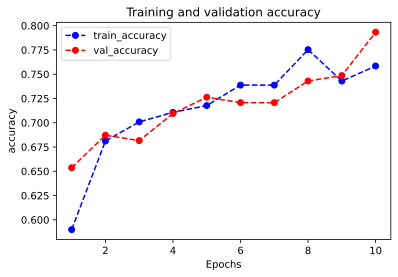

In [41]:
# 5: evaluating the model

printlog("step5: eval model...")

model.summary()

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
def plot_metric(history, metric):
  train_metrics = history.history[metric]
  val_metrics = history.history['val_' + metric]
  epochs = range(1, len(train_metrics) + 1)
  plt.plot(epochs, train_metrics, 'bo--')
  plt.plot(epochs, val_metrics, 'ro--')
  plt.title('Training and validation ' + metric)
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend(["train_" + metric, "val_" + metric])
  plt.show()

plot_metric(history, "accuracy")